In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns
from imblearn.over_sampling import SMOTE
from pygam import LogisticGAM, s, te, l, f

# Custom Python Files
from dataprep.dataPrep import cleanData
from dataprep.modelPrep import model_prep
from dataprep.modelPrep import plotROCCurve

%matplotlib inline 

In [3]:
# Larger dataset
#xcols = ['callsPerQuarter', 'assoccontacts', 'associateddeals', 'MRR', 'sessionsPerDay',"daysAsCustomer", "FF",'callcycle_numeric']

# Current best
xcols = ['callsPerQuarter','associateddeals','sessionsPerDay','callcycle_numeric']

# List of interaction terms (each their own sublist)
interactionList = [ ['callsPerQuarter', 'associateddeals'],
                    ['assoccontacts', 'associateddeals'],
                    ['assoccontacts', 'MRR'],
]

termDict = {
    "callcycle_numeric" : 2 # Higher level terms desired
}


ycol = "churn"

df = cleanData("PSCCustomerData.csv", boxcox=True)

X, y, xcolnames = model_prep(df,xcols,ycol, higherTerms=True, termDict=termDict, interactionTerms=True, interactionList = interactionList)

In [17]:
gam = LogisticGAM(n_splines = 10).gridsearch(X,y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


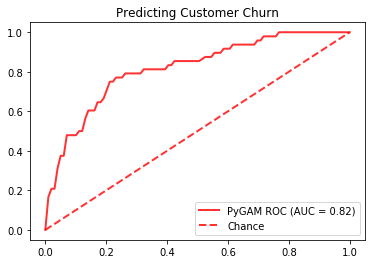

In [18]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# Plotting Setup
fig, ax = plt.subplots()

# KFold
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=1234)

# Data Range
mean_fpr = np.linspace(0, 1, 100)

# initialization params
tprs = []

for train_index,test_index in kf.split(X,y):
    xtr,xvl = X[train_index],X[test_index]
    ytr,yvl = y[train_index],y[test_index]

    # fit models
    gam.fit(X=xtr,y=ytr)

    #get prediction data
    pred_test = gam.predict_proba(xvl)

    # ROC Curve Plotting
    fpr, tpr, thresh = roc_curve(yvl, pred_test)
    interp_tpr = interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

# Return mean true positive rate & AUC
pygam_mean_tpr = np.mean(tprs, axis=0)
pygam_mean_auc = auc(mean_fpr, pygam_mean_tpr)

# PyGAM ROC Curve Plotting
ax.plot(mean_fpr, pygam_mean_tpr, color='r',
label=r'%s ROC (AUC = %0.2f)' % ('PyGAM', pygam_mean_auc),lw=2, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Predicting Customer Churn")
ax.legend(loc="lower right")
plt.show()